In [2]:
from tqdm.notebook import tqdm
from agent import Agent
from high_level_policy import HCBS
from map_handler import Map, read_map, read_tasks
from node import GridNode
import random
import glob
import os
import numpy as np
from low_level_policy import manhattan_distance, diagonal_distance
import tqdm
import matplotlib.pyplot as plt
import pickle
np.random.seed(42)
random.seed(42)

In [1]:
K = [2,4,8,12,16]

In [ ]:
def simple_test(SearchFunction, height, width, mapstr, agents, diagonal_movements=False, **kwargs):
    task_map = Map()
    task_map.read_from_string(mapstr, width, height, diagonal_movements=diagonal_movements)
    return SearchFunction(task_map, agents, **kwargs)

In [ ]:
%matplotlib inline
from IPython.display import clear_output
def massive_test(SearchFunction, map_dir, scen_dir, numbers_of_agents, title, diagonal_movements=False, **kwargs):
    results = {}
    map_files = glob.glob(os.path.join(map_dir, '*.map'))
    for k in numbers_of_agents:
        results[k] = {}
        results[k]['success'] = []
        results[k]['ctnodes_created'] = []
        results[k]['time'] = []
        for map_file in map_files:
            mapstr = read_map(map_file)
            filename = os.path.basename(map_file).replace('.map', '.scen')
            scen_path = os.path.join(scen_dir, filename)
            if k==16:
                tasks = read_tasks(scen_path, skip_first=False)[:k]
            else:
                tasks = read_tasks(scen_path)[:k]
            Agent.id = 0
            agents=[]
            for i in range(k):
                bucket, path, map_width, map_height, jStart, iStart, jGoal, iGoal, length = tasks[i]
                agents += [Agent(iStart, jStart, iGoal, jGoal)]
            sol = simple_test(SearchFunction, int(map_height), int(map_width), mapstr,
                                           agents, diagonal_movements=diagonal_movements, **kwargs)  
            if sol:
                results[k]['success'] += [True]
                results[k]['ctnodes_created'] += [sol[0]]
                results[k]['time'] += [sol[1]]
            else:
                results[k]['success'] += [False]
                results[k]['ctnodes_created'] += [np.nan]
                results[k]['time'] += [np.nan]
    return results

In [ ]:
r = massive_test(HCBS, 'generated_map', 'generated_scen', K, "CBS", diagonal_movements=False,
                 heuristic_function=manhattan_distance, 
                 use_pc=False,
                 experiment_mode=True, max_time=300)
a_file = open("no_pc.pkl", "wb")
pickle.dump(r, a_file)
a_file.close()

In [ ]:
r = massive_test(HCBS, 'generated_map', 'generated_scen', K, "CBS+PC", diagonal_movements=False,
                 heuristic_function=manhattan_distance, 
                 use_pc=True,
                 experiment_mode=True, max_time=300)
a_file = open("pc.pkl", "wb")
pickle.dump(r, a_file)
a_file.close()

In [3]:
with open("pc.pkl", "rb") as input_file:
    pc = pickle.load(input_file)

In [4]:
with open("no_pc.pkl", "rb") as input_file:
    cbs = pickle.load(input_file)

In [5]:
def generate_final_results(agent_values, cbs, pc):
    both_succeeded = {}
    for k in agent_values:
        both_succeeded[k] = np.array(pc[k]['success']) & np.array(cbs[k]['success'])
    cbs_pc_nodes={}
    cbs_pc_time={}
    cbs_nodes={}
    cbs_time={}
    for k in agent_values:
        cbs_pc_nodes[k] = np.mean(np.array(pc[k]['ctnodes_created'])[both_succeeded[k]])
        cbs_pc_time[k] = np.mean(np.array(pc[k]['time'])[both_succeeded[k]])
        cbs_nodes[k] = np.mean(np.array(cbs[k]['ctnodes_created'])[both_succeeded[k]])
        cbs_time[k] = np.mean(np.array(cbs[k]['time'])[both_succeeded[k]])
    return cbs_time, cbs_pc_time, cbs_nodes, cbs_pc_nodes
    

In [6]:
cbs_time, cbs_pc_time, cbs_nodes, cbs_pc_nodes = generate_final_results(K, cbs, pc)

In [7]:
import pandas as pd
df = pd.DataFrame(pd.Series(cbs_time))
for d in [cbs_pc_time, cbs_nodes, cbs_pc_nodes]:
    df = pd.concat([df, pd.DataFrame(pd.Series(d))], axis=1)
df.columns = ['Время, с (CBC)', 'Время, с (CBC+PC)', 'CTNodes (CBS)', 'CTNodes (CBS+PC)']
df.index.name = 'k'
df

,"Время, с (CBC)","Время, с (CBC+PC)",CTNodes (CBS),CTNodes (CBS+PC)
k,,,,
2,0.001437,0.002621,1.900000,1.900000
4,0.007425,0.011000,6.800000,5.560000
8,3.085565,0.243648,2193.938776,93.612245
12,20.321756,1.345496,13922.614286,504.785714
16,79.022291,11.631259,69603.206897,3230.827586


In [8]:
cbs_s=[]
pc_s=[]
for k in K:
    cbs_s+=[np.mean(cbs[k]['success'])]
    pc_s+=[np.mean(pc[k]['success'])]

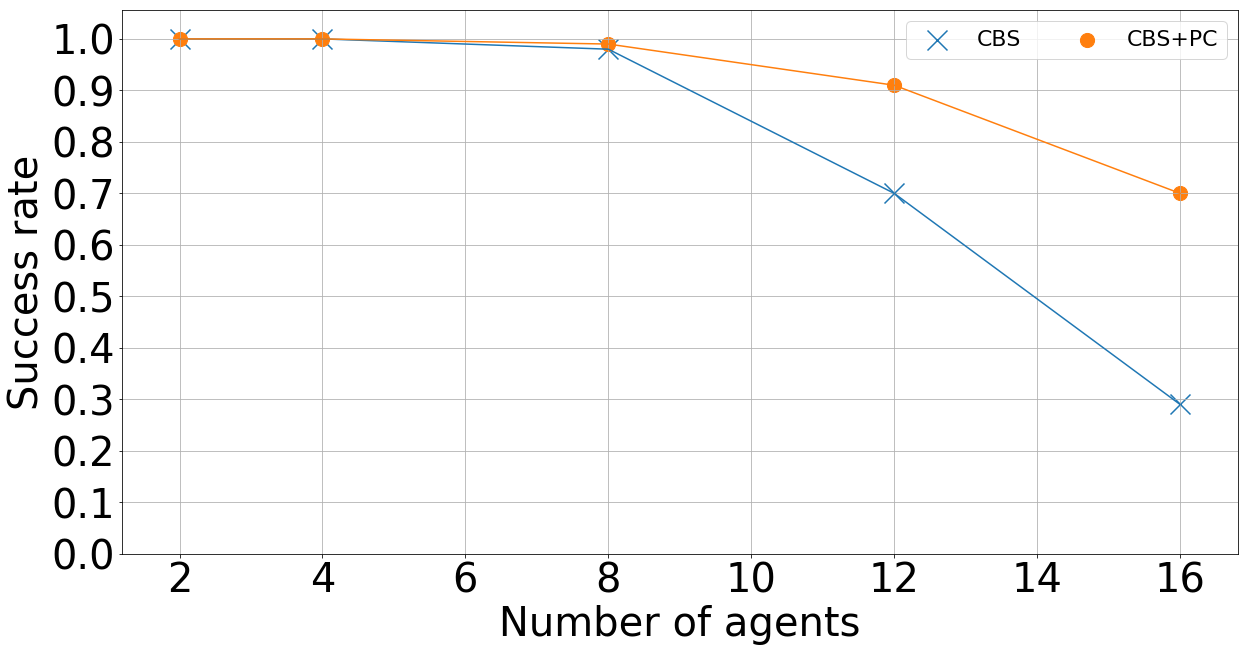

In [9]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 40})
cbs_plot = plt.scatter(K, cbs_s, marker='x', s=400)
pc_plot = plt.scatter(K, pc_s, marker='o', s=200)
plt.plot(K, cbs_s)
plt.plot(K, pc_s)
plt.grid()
plt.xlabel('Number of agents')
plt.ylabel('Success rate')
plt.yticks(np.arange(0, 1.05, 0.1))
plt.legend((cbs_plot, pc_plot), ('CBS','CBS+PC'), scatterpoints=1, ncol=3, fontsize=22)
plt.show()